In [54]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from juanfit import SpectrumFitSingle, SpectrumFitRow
import astropy.constants as const
import scipy
import scipy.signal
from skimage.restoration import wiener, richardson_lucy

In [2]:
airspec_ir3_file = "../../src/AirSpec/airspec_20170821_182352_obs03_IR3.fits"

In [3]:
with fits.open(airspec_ir3_file) as hdu:
    hdu.info()

Filename: ../../src/AirSpec/airspec_20170821_182352_obs03_IR3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (1024, 555, 536)   float32   
  1                1 ImageHDU         9   (536, 555)   float64   
  2                1 ImageHDU         9   (536, 555)   float64   
  3                1 ImageHDU         9   (536, 1024)   float64   
  4                1 BinTableHDU     20   536R x 4C   [1D, 1E, 1E, 1I]   


In [4]:
with fits.open(airspec_ir3_file) as hdu:
    ir3_data = hdu[0].data
    ir3_data_hdr = hdu[0].header
    ir3_solarx = hdu[1].data
    ir3_solary = hdu[2].data
    ir3_wavelength = hdu[3].data
    ir3_wavelength_header = hdu[3].header
    ir3_bintable_data = hdu[4].data

    ir3_unix_time = [table_col_[0] for table_col_ in ir3_bintable_data]
    ir3_exp_time = [table_col_[1] for table_col_ in ir3_bintable_data]
    ir3_fpa_temp = [table_col_[2] for table_col_ in ir3_bintable_data]
    ir3_start_row = [table_col_[3] for table_col_ in ir3_bintable_data]
    # ir3_unixtime = 

In [5]:
ir3_data_hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                  555 / length of data axis 2                          
NAXIS3  =                  536 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
TELESCOP= 'AIRSPEC '                                                            
INSTRUME= 'IR3     '                                                            
LVL_NUM = '1B      '                                                            
OBSID   =                    3                                                  
OBSLABEL= 'East limb'                                                           
DATE_OBS= '2017-08-21'      

In [6]:
ir3_data.shape

(536, 555, 1024)

In [7]:
ir3_data_aver = np.nanmean(ir3_data,axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


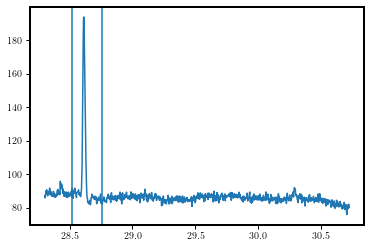

In [8]:
plt.plot(ir3_wavelength[:,0]/1000,ir3_data_aver[400,:])
plt.axvline(ir3_wavelength[830,0]/1000)
plt.axvline(ir3_wavelength[930,0]/1000)

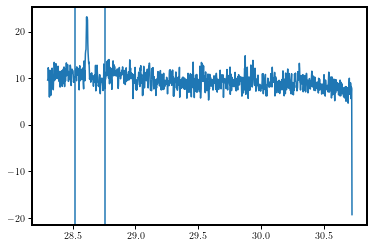

In [9]:
plt.plot(ir3_wavelength[:,0]/1000,ir3_data_aver[300,:])
plt.axvline(ir3_wavelength[830,0]/1000)
plt.axvline(ir3_wavelength[930,0]/1000)

In [10]:
np.sqrt(np.nanmean(ir3_solarx[393:414,:])**2 + np.nanmean(ir3_solary[393:414,:])**2)/950.

1.0456982393879437

<AxesSubplot:ylabel='Intensity'>

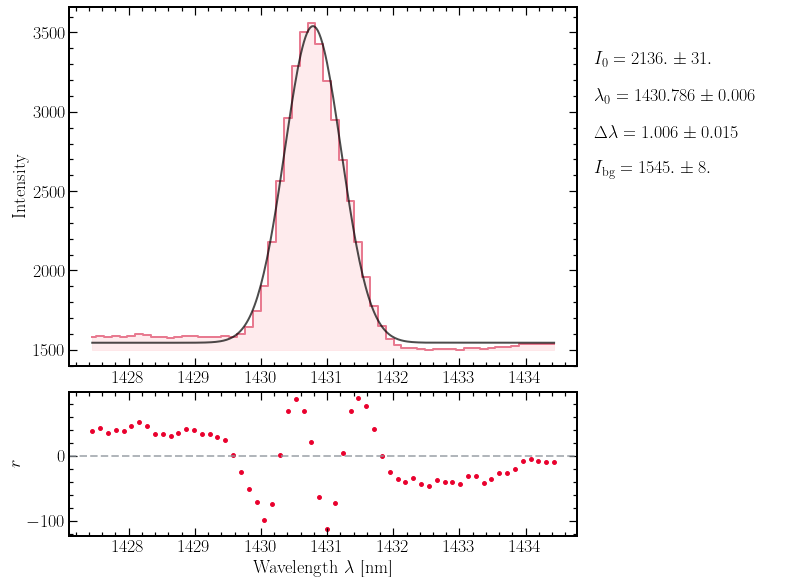

In [11]:
SiX_slice = slice(860,920)
SiX_example_data = np.nanmean(ir3_data_aver[393:414,SiX_slice],axis=0)
SiX_wvl = np.nanmean(ir3_wavelength[SiX_slice,:],axis=1)

SiX_example_fitmodel = SpectrumFitSingle(data=SiX_example_data/0.06, wvl=SiX_wvl/2/10,
                                        line_number=1,line_wvl_init=[1431],int_max_init=[3e3],fwhm_init=[1])
# SiX_example_fitmodel.plot(plot_fit=False)
SiX_example_fitmodel.run_lse(absolute_sigma=False)
SiX_example_fitmodel.plot(plot_title=None,plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{nm}]",
                        ylabel=r"Intensity")

In [12]:
SiX_dlambda_inst = 1.45/2 #4.8*np.nanmean(np.abs(np.diff(ir3_wavelength[:,0]/2./10.)))

In [13]:
SiX_fwhm_corrected = np.sqrt(SiX_example_fitmodel.fwhm_fit**2 - SiX_dlambda_inst**2)

In [14]:
SiX_Teff = (SiX_fwhm_corrected/1430*const.c.cgs.value)**2/(8*np.log(2))/const.k_B.cgs.value*28*const.u.cgs.value

In [15]:
(SiX_example_fitmodel.fwhm_fit/3/1430*const.c.cgs.value)**2/(8*np.log(2))/const.k_B.cgs.value*28*const.u.cgs.value/1e6

array([3.00110528])

In [16]:
SiX_Teff/1e6

array([12.98007442])

In [17]:
SiX_bin20_data = np.nanmean(ir3_data_aver[254:414,SiX_slice].reshape(-1,20,60),axis=1)

In [18]:
SiX_bin20_solarx = np.nanmean(ir3_solarx[254:414,:].reshape(-1,20,536),axis=(1,2))
SiX_bin20_solary = np.nanmean(ir3_solary[254:414,:].reshape(-1,20,536),axis=(1,2))
SiX_bin20_height = np.sqrt(SiX_bin20_solarx**2 + SiX_bin20_solary**2)/950.

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


array([[<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\textrm{Wavelength}$', ylabel='Intensity'>,
        <AxesSubplot:xlabel='$\\textrm{Wavelength}$'>,
        <AxesSubplot:xlabel='$\\textrm{Wavelength}$'>,
        <AxesSubplot:xlabel='$\\textrm{Wavelength}$'>]], dtype=object)

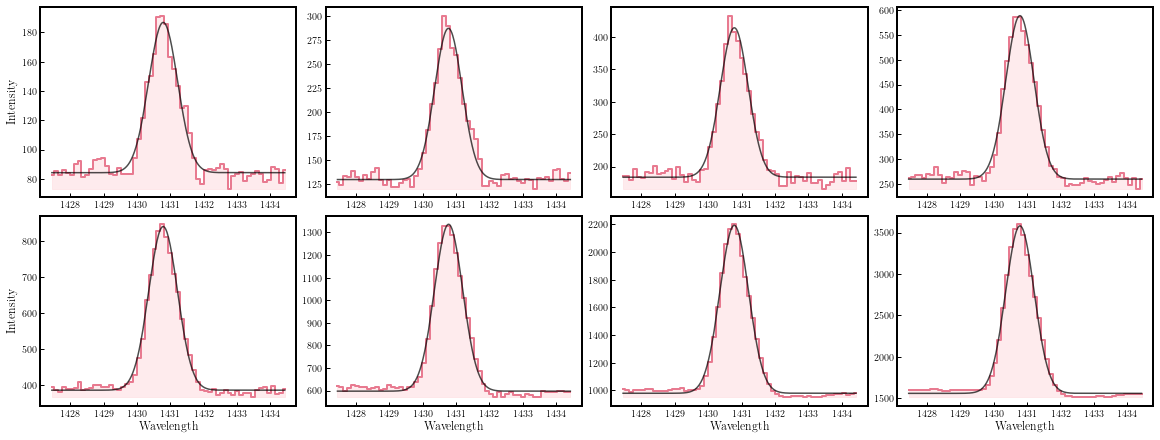

In [19]:
SiX_bin20_fitmodel = SpectrumFitRow(SiX_bin20_data/0.06, wvl=SiX_wvl/2/10,
                                        line_number=1,line_wvl_init=[1431],int_max_init=[1e3],fwhm_init=[1])

SiX_bin20_fitmodel.run_lse()
SiX_bin20_fitmodel.plot_fit()

<ErrorbarContainer object of 3 artists>

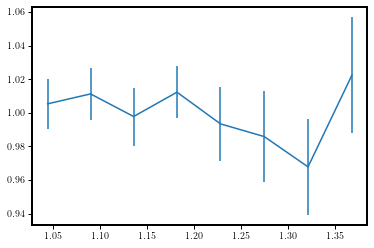

In [20]:
plt.errorbar(SiX_bin20_height, SiX_bin20_fitmodel.fwhm_fit[:,0], SiX_bin20_fitmodel.fwhm_err[:,0])

In [61]:
np.nanmean(np.abs(np.diff(ir3_wavelength[:,0]/2./10.)))

0.11830973562150345